<a href="https://colab.research.google.com/github/NevesJulio/Exercicios_DL/blob/main/ExercicioDL_07ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercícios

### Exercício 1: Experimentação com Hyperparâmetros
Teste diferentes valores de dropout rate e compare os resultados. Qual valor funciona melhor para este dataset?

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import copy
import torch.optim as optim

# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cuda


In [25]:
def criar_loader(transform, Tamanho = 5000, proporcao = 0.80):
    # Dataset completo
    full_train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True
    )
    full_test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=transform, download=True
    )

    # Criando subsets reduzidos para experimentos rápidos
    train_indices = torch.randperm(len(full_train_dataset))[:int(Tamanho*proporcao)]
    val_indices = torch.randperm(len(full_test_dataset))[:int(Tamanho*(1-proporcao))]

    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_test_dataset, val_indices)

    # DataLoaders
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [26]:
# Preparação do dataset MNIST reduzido
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader, val_loader = criar_loader(transform)

In [3]:
# Modelo base simples para demonstrar overfitting
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [8]:
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001, dropout_rate = 0.0, weight_decay = 0.0):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

In [5]:
# Definir diferentes tamanhos de dataset para o experimento
batch_size = 64
epochs = 20
Dropout = [0.30, 0.50, 0.70]
LR = 0.01

# Inicializar dicionários para armazenar resultados
results_by_size = {}
models_by_size = {}

In [6]:
# Executar experimentos para cada tamanho de dataset
for dr in Dropout:
    print(f"Treinando com dropout rate de: {dr}...")
    model = BaseModel(dropout_rate = dr)
    # Treinar modelo
    model, history = train_model(model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=LR
    )

    # Armazenar resultados
    results_by_size[dr] = history
    models_by_size[dr] = model

Treinando com dropout rate de: 0.3...
Época 5/20: Train Loss: 0.3692, Train Acc: 88.97% | Val Loss: 0.3261, Val Acc: 91.70%
Época 10/20: Train Loss: 0.3163, Train Acc: 91.10% | Val Loss: 0.3710, Val Acc: 91.00%
Época 15/20: Train Loss: 0.3366, Train Acc: 90.90% | Val Loss: 0.3671, Val Acc: 91.70%
Época 20/20: Train Loss: 0.2870, Train Acc: 92.50% | Val Loss: 0.4304, Val Acc: 91.60%
Concluído para o dropout0.3
Treinando com dropout rate de: 0.5...
Época 5/20: Train Loss: 0.6176, Train Acc: 81.92% | Val Loss: 0.3528, Val Acc: 89.90%
Época 10/20: Train Loss: 0.5754, Train Acc: 82.60% | Val Loss: 0.3798, Val Acc: 89.70%
Época 15/20: Train Loss: 0.5189, Train Acc: 86.25% | Val Loss: 0.4224, Val Acc: 89.90%
Época 20/20: Train Loss: 0.5636, Train Acc: 84.05% | Val Loss: 0.4291, Val Acc: 90.70%
Concluído para o dropout0.5
Treinando com dropout rate de: 0.7...
Época 5/20: Train Loss: 1.0888, Train Acc: 68.03% | Val Loss: 0.5328, Val Acc: 86.50%
Época 10/20: Train Loss: 1.1578, Train Acc: 64.58%

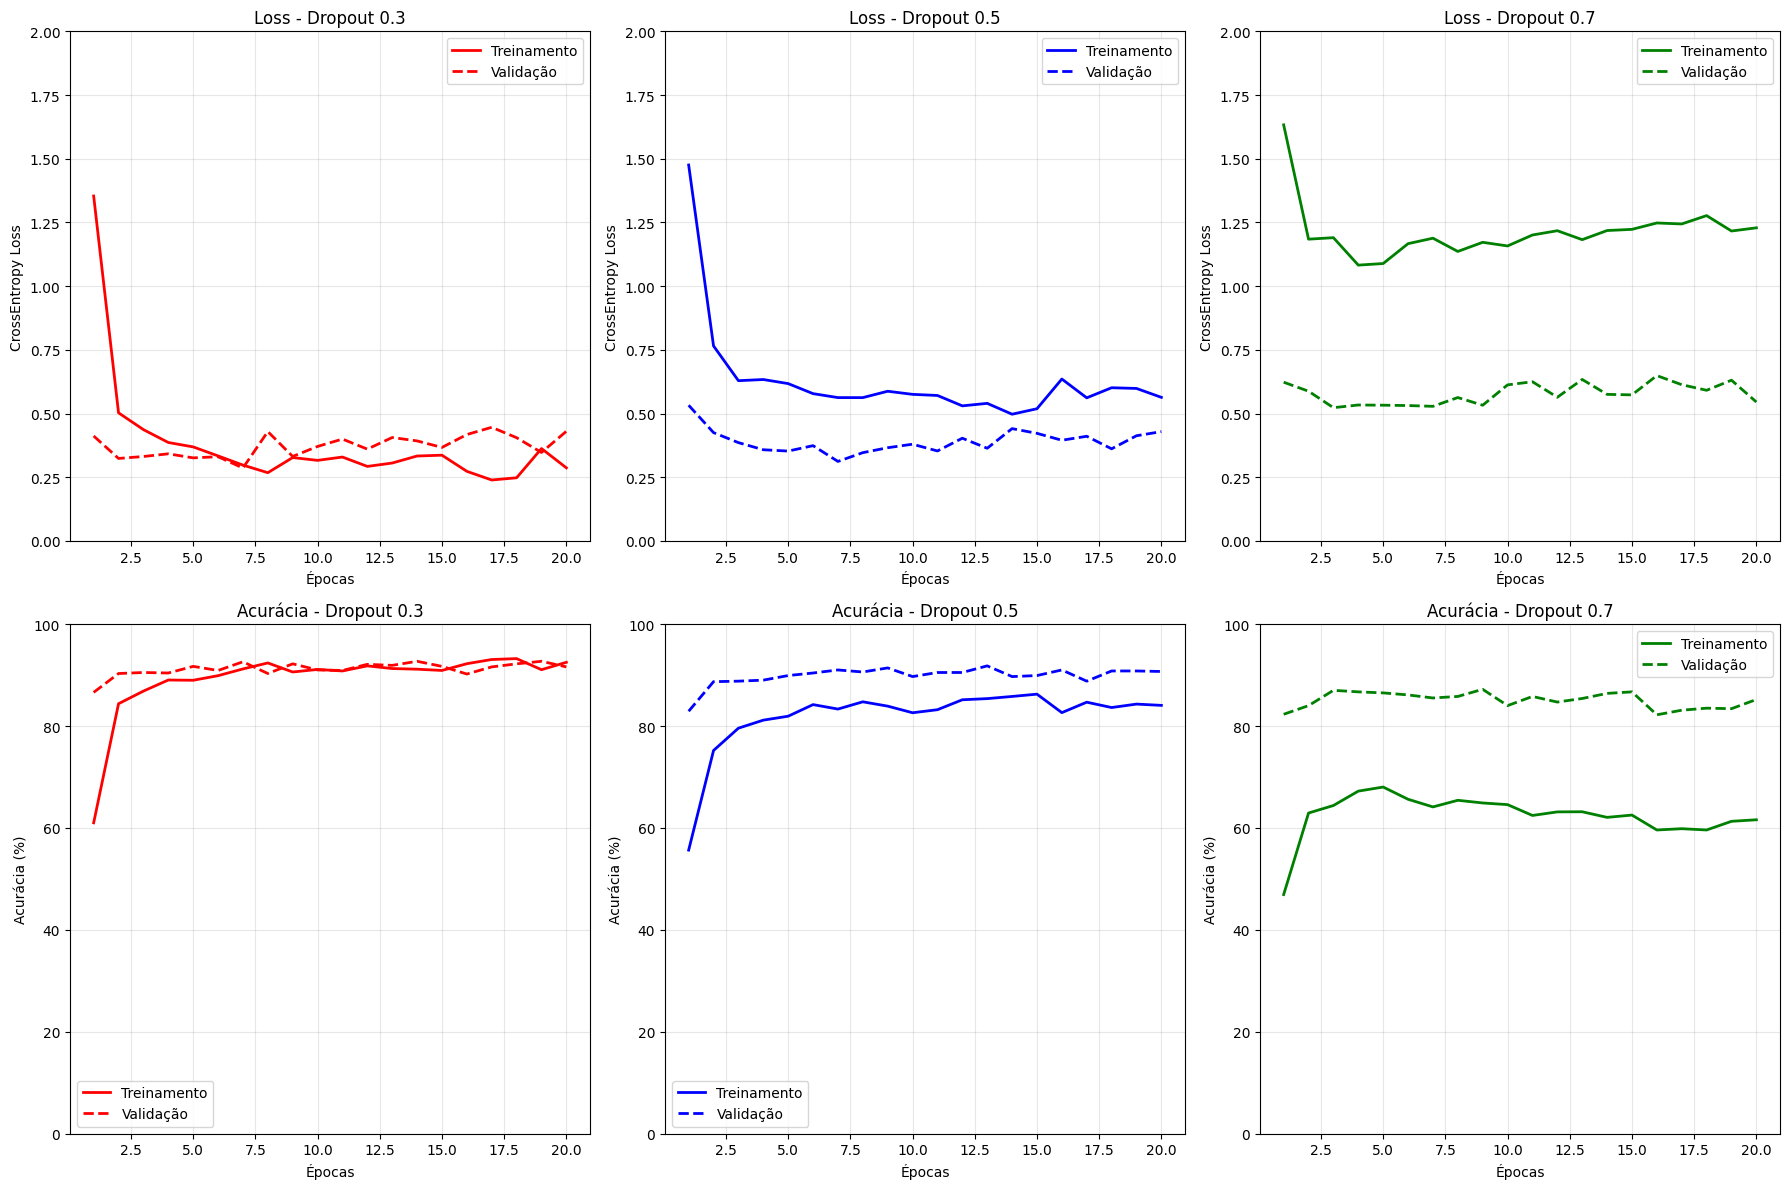

In [7]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, dr in enumerate(Dropout):   # i = 0,1,2 ; dr = dropout
    history = results_by_size[dr]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)

    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')

    ax_loss.set_title(f'Loss - Dropout {dr}')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')

    ax_acc.set_title(f'Acurácia - Dropout {dr}')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

plt.tight_layout()
plt.show()


Podemos ver que um dropout baixo a médio da um bom desempenho evitando o overfitting nos 2 casos, para esses dados, já um valor de dropout muito limita muito a melhora do treinamento diminuindo o desempenho.

### Exercício 2: Combinação de Técnicas
Crie um modelo que combine dropout com regularização L2. Compare com os modelos individuais.


In [9]:
def plot_training_curves(results_dict, labels, colors=None):
    """
    Plota curvas de loss e acurácia para múltiplos experimentos.

    results_dict: dict {label: history_dict}
    labels: lista de labels na ordem dos plots (ex: lista de dropouts)
    colors: lista de cores (opcional)
    """
    if colors is None:
        colors = ['r', 'b', 'g', 'm', 'c', 'y']

    fig, axes = plt.subplots(2, len(labels), figsize=(6 * len(labels), 10))

    for i, label in enumerate(labels):
        history = results_dict[label]
        color = colors[i % len(colors)]

        epochs_range = range(1, len(history['train_losses']) + 1)

        # --- LOSS ---
        ax_loss = axes[0, i]
        ax_loss.plot(epochs_range, history['train_losses'],
                     f'{color}-', linewidth=2, label='Treinamento')
        ax_loss.plot(epochs_range, history['val_losses'],
                     f'{color}--', linewidth=2, label='Validação')

        ax_loss.set_title(f'Loss - {label}')
        ax_loss.set_xlabel('Épocas')
        ax_loss.set_ylabel('CrossEntropy Loss')
        ax_loss.grid(True, alpha=0.3)
        ax_loss.set_ylim([0, 2])
        ax_loss.legend()

        # --- ACURÁCIA ---
        ax_acc = axes[1, i]
        ax_acc.plot(epochs_range, history['train_accuracies'],
                    f'{color}-', linewidth=2, label='Treinamento')
        ax_acc.plot(epochs_range, history['val_accuracies'],
                    f'{color}--', linewidth=2, label='Validação')

        ax_acc.set_title(f'Acurácia - {label}')
        ax_acc.set_xlabel('Épocas')
        ax_acc.set_ylabel('Acurácia (%)')
        ax_acc.grid(True, alpha=0.3)
        ax_acc.set_ylim([0, 100])
        ax_acc.legend()

    plt.tight_layout()
    plt.show()


In [13]:
results = {}
models = {}

#Dropout ---
print("Treinando modelo com Dropout...")
model_dropout = BaseModel(dropout_rate=0.5)
models['dropout'], results['dropout'] = train_model(
    model_dropout,
    train_loader,
    val_loader,
    epochs=20,
    lr=0.001,
    weight_decay=0.0
)

#L2
print("Treinando modelo com L2...")
model_l2 = BaseModel(dropout_rate=0.0)
models['l2'], results['l2'] = train_model(
    model_l2,
    train_loader,
    val_loader,
    epochs=20,
    lr=0.001,
    weight_decay=1e-3
)

#Dropout + L2
print("Treinando modelo com Dropout + L2...")
model_both = BaseModel(dropout_rate=0.5)
models['both'], results['both'] = train_model(
    model_both,
    train_loader,
    val_loader,
    epochs=20,
    lr=0.001,
    weight_decay=1e-4
)


Treinando modelo com Dropout...
Época 5/20: Train Loss: 0.2750, Train Acc: 91.22% | Val Loss: 0.2395, Val Acc: 92.60%
Época 10/20: Train Loss: 0.1363, Train Acc: 95.92% | Val Loss: 0.2141, Val Acc: 94.10%
Época 15/20: Train Loss: 0.0958, Train Acc: 97.12% | Val Loss: 0.1989, Val Acc: 94.60%
Época 20/20: Train Loss: 0.0595, Train Acc: 98.17% | Val Loss: 0.2020, Val Acc: 94.50%
Treinando modelo com L2...
Época 5/20: Train Loss: 0.1133, Train Acc: 96.97% | Val Loss: 0.2489, Val Acc: 92.80%
Época 10/20: Train Loss: 0.0273, Train Acc: 99.53% | Val Loss: 0.2636, Val Acc: 92.30%
Época 15/20: Train Loss: 0.0112, Train Acc: 99.92% | Val Loss: 0.2132, Val Acc: 93.80%
Época 20/20: Train Loss: 0.0082, Train Acc: 100.00% | Val Loss: 0.2069, Val Acc: 94.00%
Treinando modelo com Dropout + L2...
Época 5/20: Train Loss: 0.2627, Train Acc: 91.80% | Val Loss: 0.2425, Val Acc: 92.70%
Época 10/20: Train Loss: 0.1305, Train Acc: 95.67% | Val Loss: 0.2099, Val Acc: 93.40%
Época 15/20: Train Loss: 0.0848, Tra

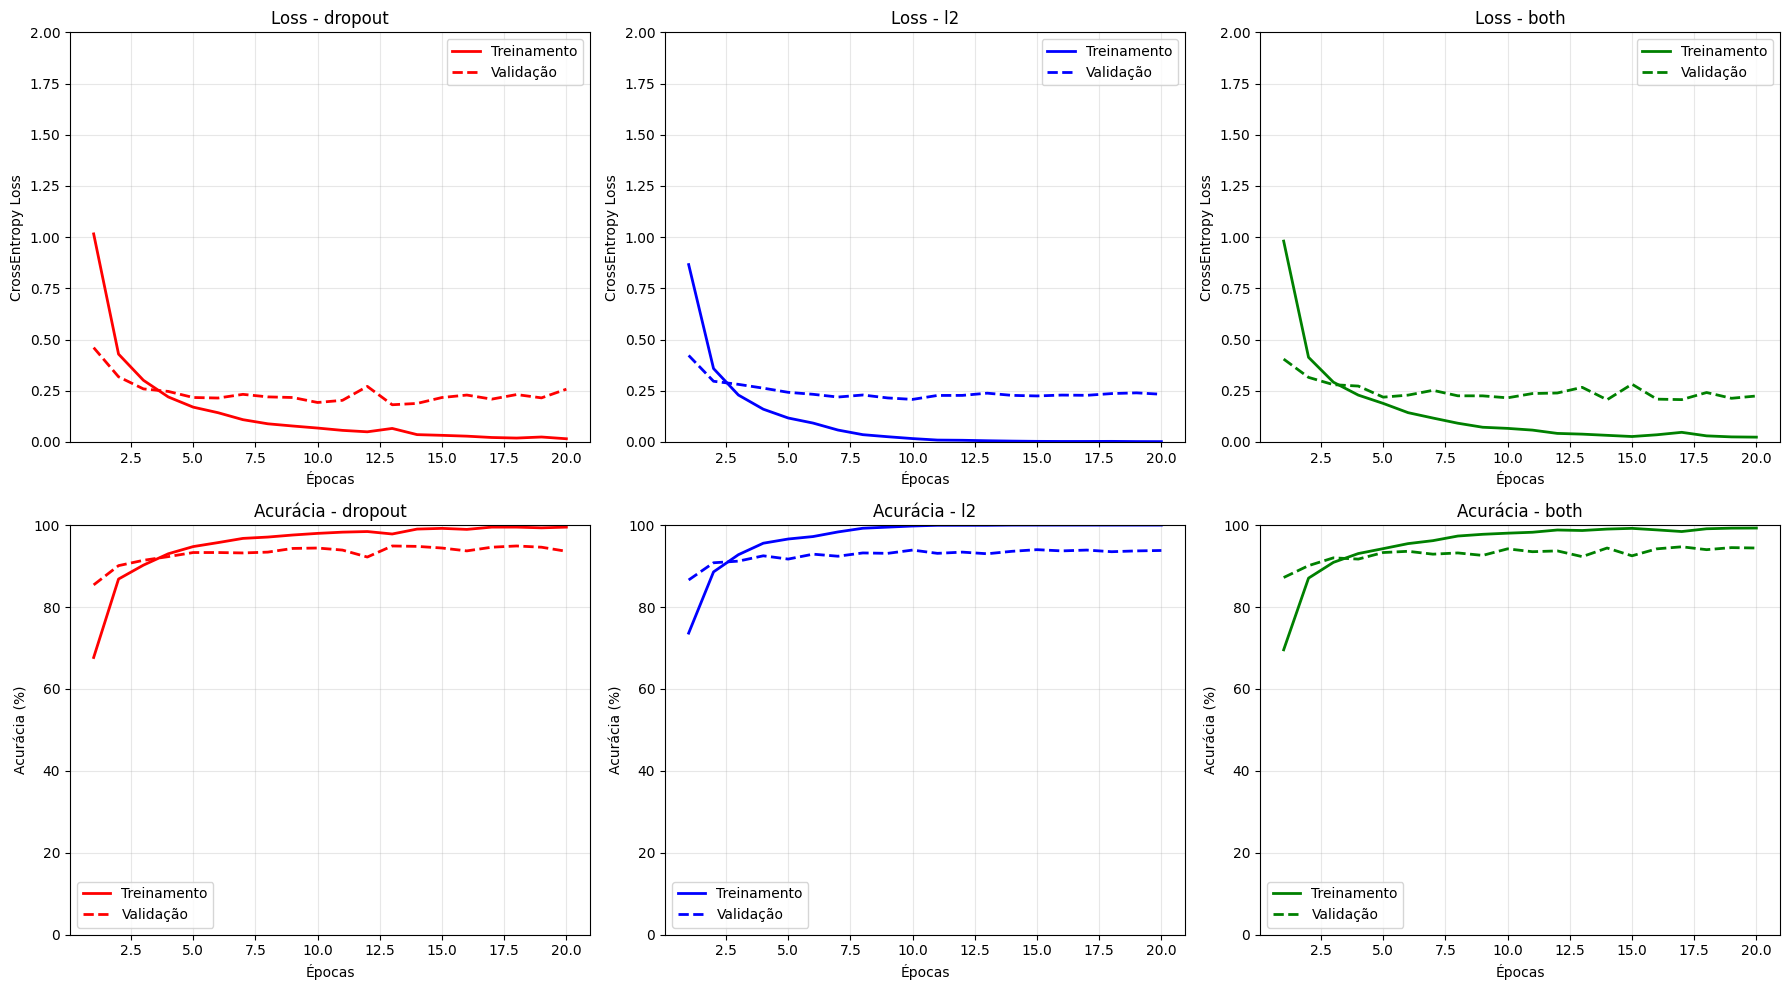

In [11]:
plot_training_curves(results, ['dropout', 'l2', 'both'])

### Exercício 3: Data Augmentation Customizado
Experimente diferentes transformações de data augmentation (veja a documentação do TorchVision).

In [14]:
transform_light = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform_medium = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.15, 0.15),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


transform_strong = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.25, 0.25),
        scale=(0.8, 1.2),
        shear=20
    ),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [18]:
Augmentation = [transform_light, transform_medium, transform_strong]
AugNames = ["light", "medium", "strong"]

results = {}
models = {}

for transform, name in zip(Augmentation, AugNames):

    print(f"\nTreinando com augmentation: {name}")

    # cria os loaders usando este augmentation
    train_loader, val_loader = criar_loader(transform)

    # cria o modelo
    model = BaseModel()

    # treina normalmente
    model, history = train_model(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=LR
    )

    # salva resultados
    results[name] = history
    models[name] = model

    print(f"Concluído para: {name}")

print("\nTodos os experimentos concluídos!")


Treinando com augmentation: light
Época 5/20: Train Loss: 0.1880, Train Acc: 94.00% | Val Loss: 0.3251, Val Acc: 91.10%
Época 10/20: Train Loss: 0.1326, Train Acc: 96.10% | Val Loss: 0.3195, Val Acc: 92.80%
Época 15/20: Train Loss: 0.1349, Train Acc: 96.30% | Val Loss: 0.3792, Val Acc: 91.50%
Época 20/20: Train Loss: 0.1323, Train Acc: 96.15% | Val Loss: 0.4788, Val Acc: 91.90%
Concluído para: light

Treinando com augmentation: medium
Época 5/20: Train Loss: 0.7004, Train Acc: 76.62% | Val Loss: 0.7111, Val Acc: 77.20%
Época 10/20: Train Loss: 0.6049, Train Acc: 81.20% | Val Loss: 0.5985, Val Acc: 81.70%
Época 15/20: Train Loss: 0.5771, Train Acc: 82.65% | Val Loss: 0.5652, Val Acc: 82.30%
Época 20/20: Train Loss: 0.4770, Train Acc: 84.88% | Val Loss: 0.4872, Val Acc: 83.80%
Concluído para: medium

Treinando com augmentation: strong
Época 5/20: Train Loss: 1.6074, Train Acc: 44.98% | Val Loss: 1.4306, Val Acc: 50.30%
Época 10/20: Train Loss: 1.3556, Train Acc: 54.33% | Val Loss: 1.332

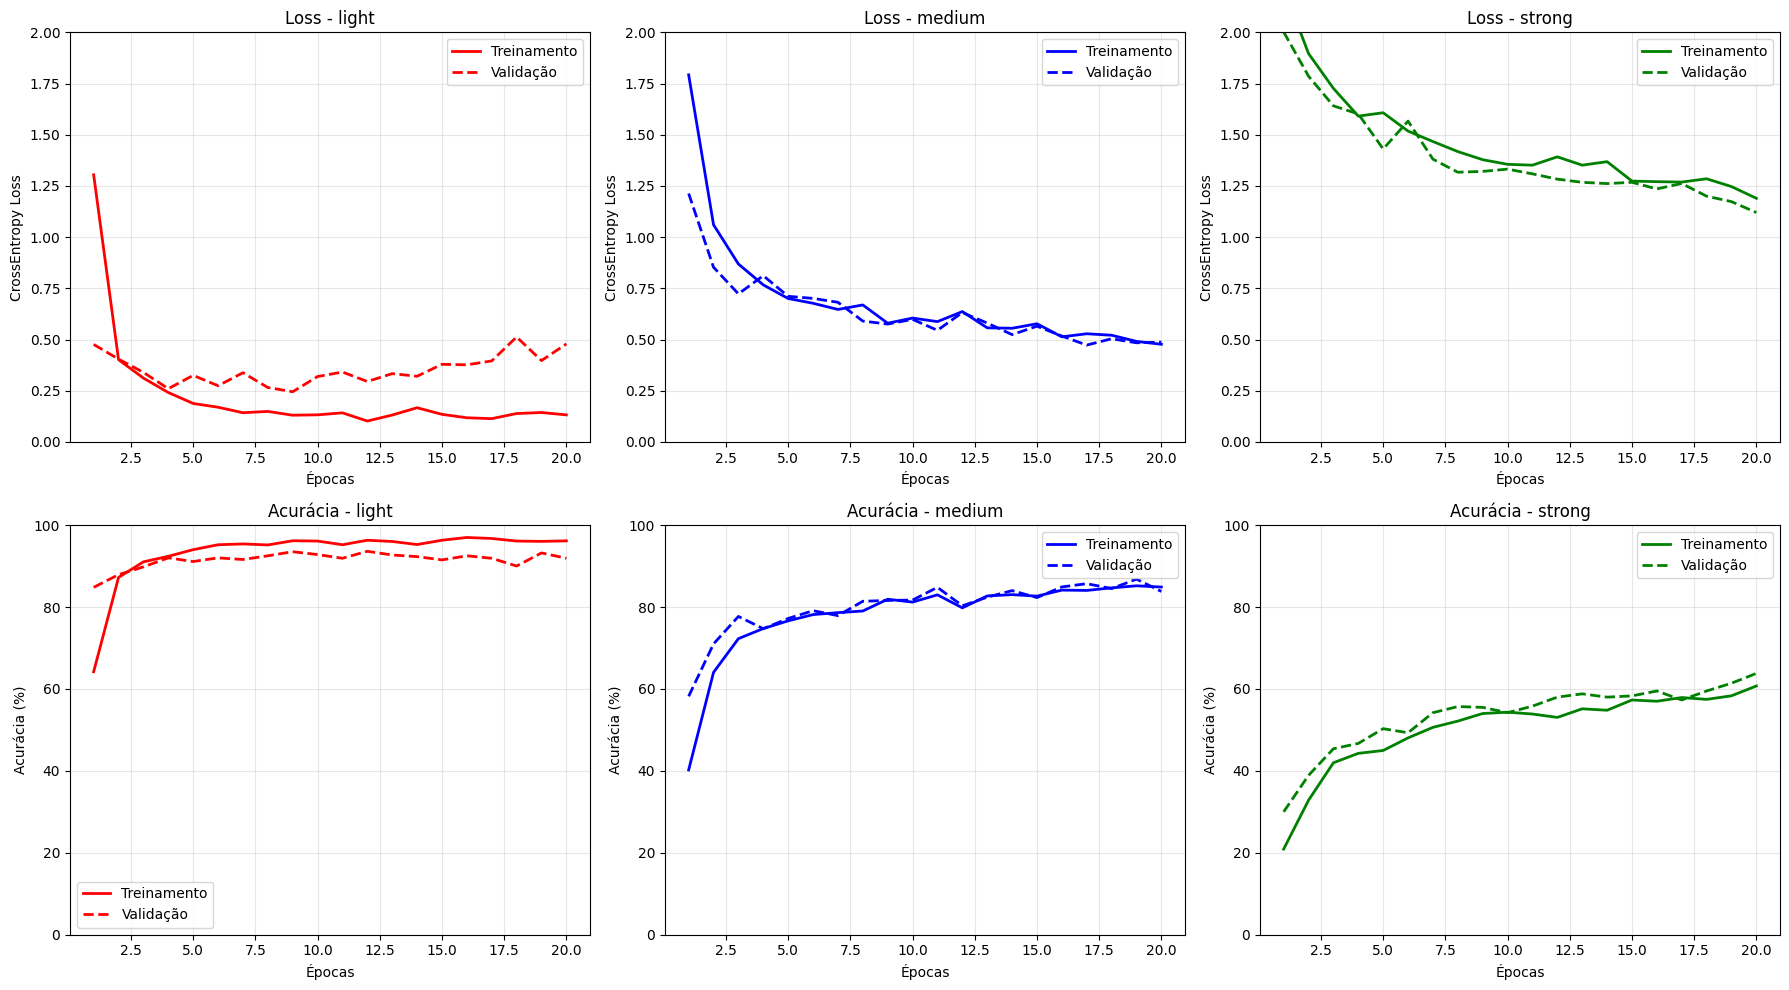

In [19]:
plot_training_curves(results, ["light", "medium", "strong"])

Comparando 3 casos de data augmentation da mais leve até a mais agressiva, vemos que embora o primeiro caso tenha um leve overfitting ainda tem um grande desempenho de acurácia, nas seguintes embora consiga tirar o overfitting decaiu muito o desempenho das redes.

### Exercício 4: Análise de Overfitting
Use um dataset ainda menor (1000 amostras de treino) e compare como cada técnica de regularização se comporta em um cenário de overfitting mais severo.

In [21]:
AugNames = ["Dropout", "L2", "DataAugmentation"]
results = {}
models = {}

In [27]:

#Dropout ---
train_loader, val_loader = criar_loader(transform, Tamanho = 1000)
print("Treinando modelo com Dropout...")
model_dropout = BaseModel(dropout_rate=0.3)
models['Dropout'], results['Dropout'] = train_model(
    model_dropout,
    train_loader,
    val_loader,
    epochs=20,
    lr=0.001,
    weight_decay=0.0
)



Treinando modelo com Dropout...
Época 5/20: Train Loss: 0.3522, Train Acc: 89.62% | Val Loss: 0.4774, Val Acc: 85.93%
Época 10/20: Train Loss: 0.1350, Train Acc: 96.12% | Val Loss: 0.4021, Val Acc: 88.94%
Época 15/20: Train Loss: 0.0488, Train Acc: 98.75% | Val Loss: 0.4343, Val Acc: 87.44%
Época 20/20: Train Loss: 0.0262, Train Acc: 99.62% | Val Loss: 0.3846, Val Acc: 89.45%


In [28]:
#L2
print("Treinando modelo com L2...")
train_loader, val_loader = criar_loader(transform, Tamanho = 1000)
model_l2 = BaseModel(dropout_rate=0.0)
models['L2'], results['L2'] = train_model(
    model_l2,
    train_loader,
    val_loader,
    epochs=20,
    lr=0.001,
    weight_decay=1e-3
)


Treinando modelo com L2...
Época 5/20: Train Loss: 0.2474, Train Acc: 93.88% | Val Loss: 0.3071, Val Acc: 91.46%
Época 10/20: Train Loss: 0.0767, Train Acc: 98.12% | Val Loss: 0.2809, Val Acc: 92.46%
Época 15/20: Train Loss: 0.0134, Train Acc: 100.00% | Val Loss: 0.2588, Val Acc: 91.96%
Época 20/20: Train Loss: 0.0069, Train Acc: 100.00% | Val Loss: 0.2491, Val Acc: 92.96%


In [31]:
#DataAugmentation
print("Treinando modelo com DataAugmentation...")
train_loader, val_loader = criar_loader(transform_light, Tamanho = 1000)
model_both = BaseModel(dropout_rate=0.0)
models['DataAugmentation'], results['DataAugmentation'] = train_model(
    model_both,
    train_loader,
    val_loader,
    epochs=20,
    lr=0.001,
    weight_decay=0.0
)

Treinando modelo com DataAugmentation...
Época 5/20: Train Loss: 0.3765, Train Acc: 88.75% | Val Loss: 0.4041, Val Acc: 86.93%
Época 10/20: Train Loss: 0.1298, Train Acc: 96.38% | Val Loss: 0.3421, Val Acc: 89.45%
Época 15/20: Train Loss: 0.0678, Train Acc: 97.88% | Val Loss: 0.3695, Val Acc: 87.94%
Época 20/20: Train Loss: 0.0535, Train Acc: 99.00% | Val Loss: 0.2677, Val Acc: 90.45%


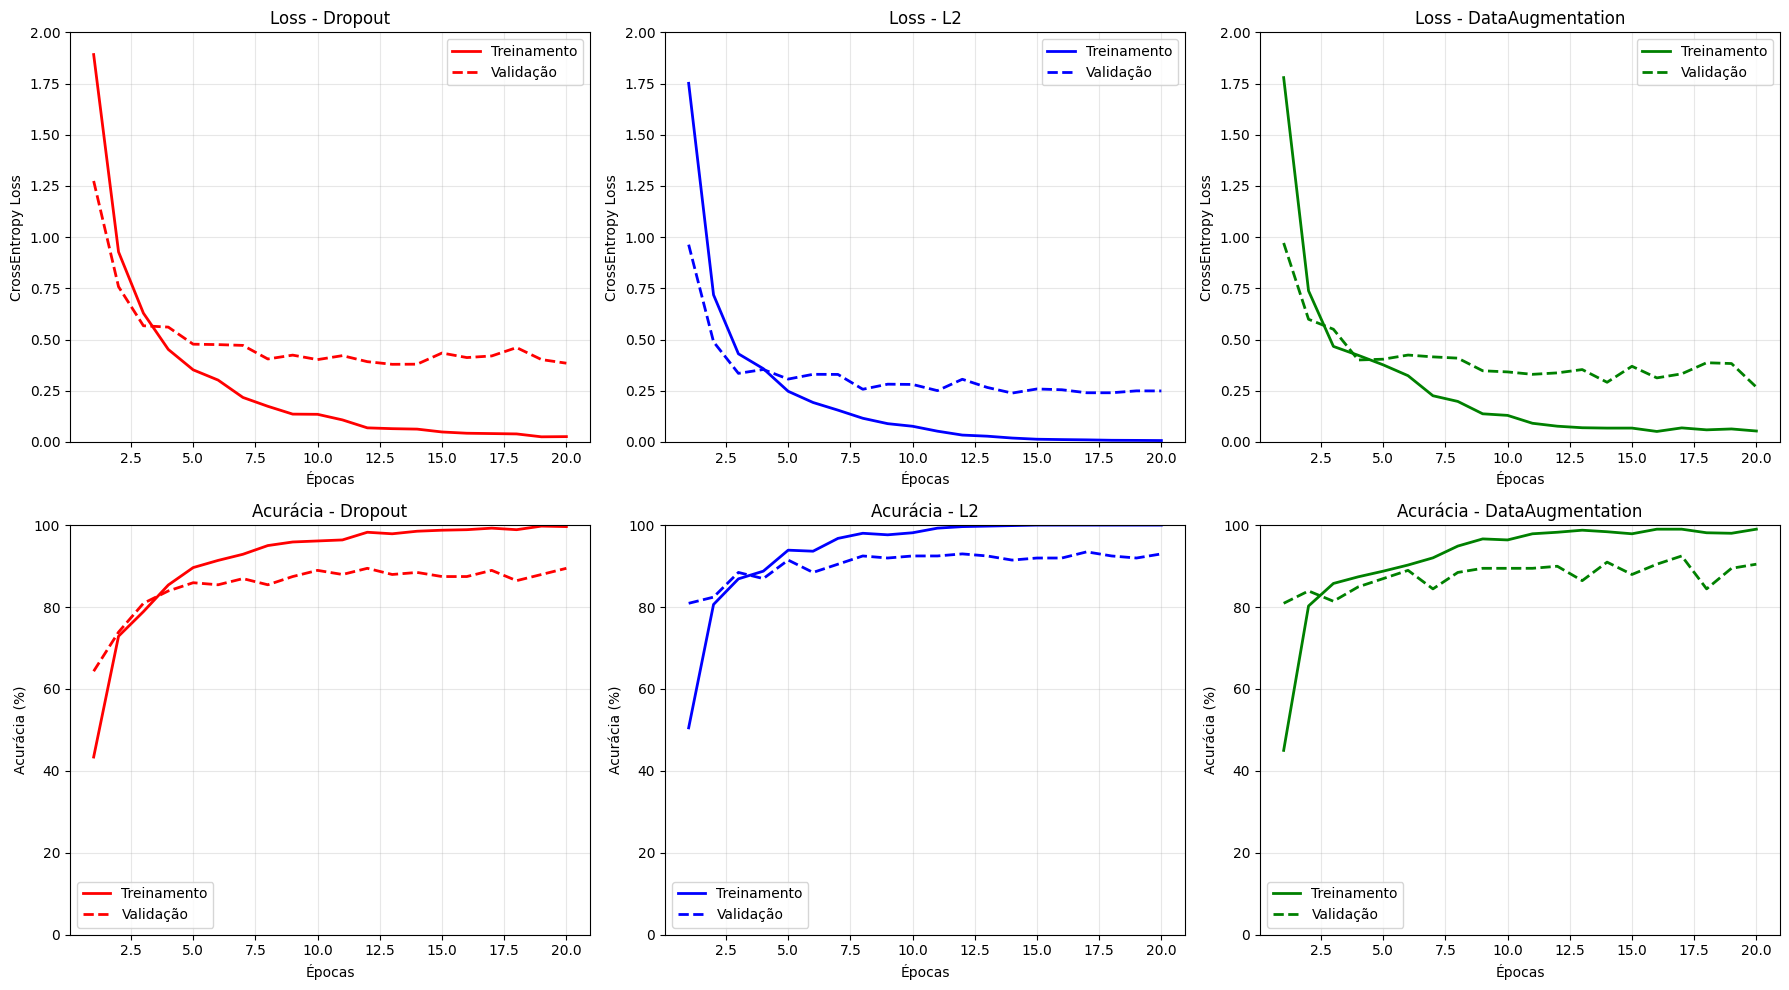

In [32]:
plot_training_curves(results, ["Dropout", "L2", "DataAugmentation"])

Foi observado que com essa situação crítica de redução de dados, em todas as situações estão em situação de overfitting, mas o menor gap está ocorrendo na regularização L2,